# Lecture 7: hands-on variational quantum classifier

It's time to apply what you've learned about quantum states, gates, and expectation values: in this hands-on class we will implement a quantum algorithm to perform binary classification of data.

After working through this notebook, you will be able to:
 - describe the structure of variational quantum algorithms
 - compute the gradient of circuit parameters with PennyLane
 - describe strategies for data embeddings and circuit ansatz design in variational algorithms
 - classify data with a variational quantum classifier

You may work in groups of up to 4 students. This hands-on is counted as one of the course assignments, and the submission deadline is Monday Feb. 5 at 11:59pm.

In [2]:
import pennylane as qml
from pennylane import numpy as np
# You may need to install matplotlib in your environment
# if you do not already have it.
import matplotlib.pyplot as plt

## Part 1: Expectation values and quantum gradients

Consider the circuit below with a single parameter that computes the expectation value $\langle Z \rangle$.

<img src="fig/circuit-1.1ry.png" width="300px"> 


In class, we learned that the expectation value of an observable, $B$, for state $\vert \psi \rangle$ can be computed analytically by the formula

$$
\langle B \rangle = \langle \psi \vert B \vert \psi \rangle
$$

Since for our circuit, $\vert \psi \rangle = RY(\theta) \vert 0 \rangle$, we find that $\langle Z \rangle$ itself is a *function of* $\theta$, i.e., 

$$
f(\theta) = \langle Z \rangle = \langle 0 |  RY^\dagger(\theta) B  RY(\theta) \vert 0 \rangle
$$

This means that we can take the gradient of $\langle Z \rangle$ (or any observable) with respect to $\theta$.

**Exercise 1.1.** (2 points) Code up a QNode for the circuit above, that takes as input a single parameter `theta`, and execute it for an arbitrary value of `theta`.

You probably noticed that the outputs of PennyLane are not normal NumPy arrays, as they have a parameter called `requires_grad`. Under the hood, PennyLane is implemented on top of various automatic differentiation (autodiff) software libraries that allow us to automatically compute gradients of functions with respect to input parameters, even those that come out of a quantum circuit!

This can be done using the `qml.grad` function. It takes a function as input, and returns a function (with the same signature) that computes the gradient of the input function. To see how this works, try out the example below.

In [ ]:
def f(x):
    return x ** 2

grad_f = qml.grad(f)

# Call grad_f with input x.
# We set x to be a PennyLane NumPy array so that it knows to take the gradient
x = np.array(3.0, requires_grad=True)
grad_f(x)

**Exercise 1.2.** (1 point) Compute the gradient of your QNode from Exercise 1.1. Then, plot the following quantities for a range of angles between $-\pi$ and $\pi$:
 - the output expectation value of the circuit
 - the gradient of the expectation value of the circuit

Do your results make sense? Provide some rationale in the box below.

In [ ]:
##################
# YOUR CODE HERE #
##################
# Set up a function to compute gradient values of your QNode, then run it


In [ ]:
# Generate 100 angles between -π and π
angles = np.linspace(-np.pi, np.pi, 100)

##################
# YOUR CODE HERE #
##################
# Evaluate the expectation values and gradients for provided angles
expectation_values = [circuit(x) for x in angles]
gradient_values = [grad_f(x) for x in angles] 

# Code for plotting 
plt.plot(angles, expectation_values, label="Exp. val.")
plt.plot(angles, gradient_values, label="Grad.")
plt.xlabel("θ")
plt.ylabel("Expval/grad")
plt.legend()

The ability to compute gradients means we can *train* quantum circuits to achieve a specific outcome. For example, consider the slightly modified circuit below. 

<img src="fig/circuit-1.3ry.png" width="300px"> 

**Exercise 1.3.** (1 point) What is the minimum value of $\langle Z \rangle$? Then, consider the above circuit: if we apply a Hadamard then rotate with $RY(\theta)$, for what value of $\theta$ will the expectation value $\langle Z \rangle$ be minimized?

**Exercise 1.4**. (1 point) The code below will find the minimum value of $\theta$ by performing optimization through *gradient descent*. Study the code, then execute it. Does it align with what you guessed in exercise 1.3? (Discuss why or why not)

In [ ]:
# First we set up our device and QNode
dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev)
def circuit(theta):
    qml.Hadamard(wires=0)
    qml.RY(theta, wires=0)
    return qml.expval(qml.PauliZ(0))

# We now define a cost function for the optimization problem
# For this case, the cost is the output expectation value of the circuit,
# so we don't technically need to define a separate function. 
# We do so here just for a nicer abstraction.
def cost(x):
    return circuit(x)

# A PennyLane object that will manage the optimization for us
opt = qml.GradientDescentOptimizer(stepsize=0.1)

# Number of iterations in the optimization, initial value of 
# theta, and arrays to hold intermediate results
num_iterations = 50
theta = np.array(0.3)
thetas = []
expvals = []

# Run the optimization loop: for each theta, perform one 
# gradient descent step, and store the results
for _ in range(num_iterations):
    theta, expval = opt.step_and_cost(cost, theta)
    
    thetas.append(theta)
    expvals.append(expval)

In [ ]:
plt.plot(thetas, label="θ")
plt.plot(expvals, label="<Z>")
plt.xlabel("Iteration")
plt.ylabel("Expval or θ")
plt.legend()

**Exercise 1.5**. (2 points) Suppose you wish to train a circuit with the same structure to prepare the $|-\rangle$ state. What is a suitable observable to measure as the cost, and why?

<img src="fig/circuit-1.5ry.png" width="500px"> 
 Then, using the code from Exercise 1.4 as a starting point, train your circuit to find the optimal value of $\theta$.

## Part 2: The variational quantum classifier

While we have quantum computers today, they are noisy and we can't run very long algorithms on them. However, researchers try to make the best of these devices by developing new types of algorithms that are more suitable, such as *variational quantum algorithms* (VQAs). VQAs work by training parametrized circuits to solve problems. They are built around an iterative exchange between a quantum computer, which runs parametrized circuits and returns measurements, and a classical computer, which interprets those measurement results and informs the quantum computer what to do next.

<img src="fig/vqa.png" width="500px">

One application of VQAs is machine learning. In fact, trainable, parametrized circuits are sometimes called *quantum neural networks* because we can train them much as we would a regular neural network. A common machine learning task is *binary classification*, the process of determining whether some input data belongs to one of two classes. This is depicted below for both a classical neural network (left) and a quantum neural network (right).

<img src="fig/nn-qnn.png" width="800px"> 

In a quantum neural network, classical data is first loaded up, or *embedded*, into a circuit by applying quantum gates whose parameters depend on the data (the yellow block). Then, a circuit with *trainable* parameters is executed (pink part). The actual classification is done at the end based on measurement outcomes (the blue part). The idea is that the trainable part will learn where to "send" quantum states such that the measurement output can be correctly interpreted as either one class or the other.

Below, we will load up and plot some data that you will use a quantum circuit to classify.

In [3]:
from lecture07_helpers import *

train_X, train_y, test_X, test_y = load_hands_on_data()

Text(0.5, 1.0, 'Training data')

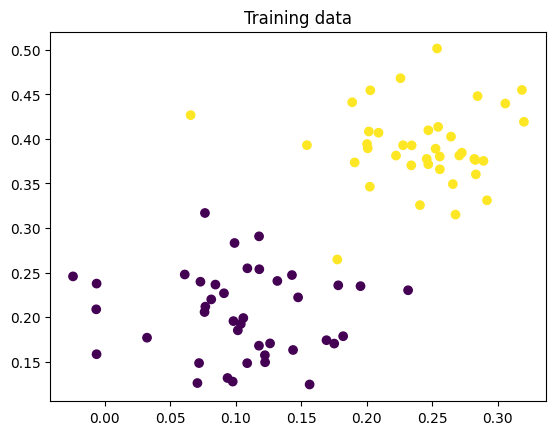

In [4]:
plot_data(train_X, train_y)
plt.title("Training data")

Text(0.5, 1.0, 'Test data')

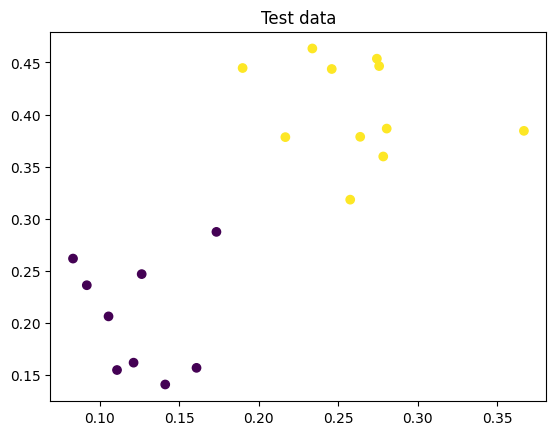

In [5]:
plot_data(test_X, test_y)
plt.title("Test data")

Next, you'll work through steps to design your own variational classifier. You'll need to decide:
 - how to encode the input data
 - what the structure of the  p u etrized structure should look like
 - what observable l d   sure, and how to use that result to perform a classification

### Part 2.1: Encoding

**Exercise 2.1**. (1 point) As you can see from the plots, we are working with 2-dimensional input data. It makes sense, then, that our encoding circuit should perform at least two parametrized gates that depend on them. A sensible option is to use 2 qubits, and have each one "manage" one part of the data vector. In the function below, apply some rotations to each of two qubits depending on the input data. You may select some gates on your own, or take a look at PennyLane's [embedding templates](https://docs.pennylane.ai/en/stable/introduction/templates.html#embedding-templates) for inspiration.

In [ ]:
dev = qml.device("default.qubit", wires=2)

def encode(data_point):
    ##################
    # YOUR CODE HERE #
    ##################
    # Apply some quantum gates to two qubits based on the 2-element 
    # vector data_point


After the data is encoded, the next step is to design the trainable part of the circuit, often called the *ansatz* circuit. This generally consists of repeated layers of parametrized single-qubit gates, and non-parametrized two-qubit gates. Cartoons of some common structures are depicted below (the coloured single-qubit gates may correspond to $RX$, $RY$, etc.):

<img src="fig/ansatze.png" width="400px"> 

These are the gates that, once trained, will map the states prepared in the embedding procedure into parts of the 2-qubit space with measurement outcomes we can interpret as classes.

**Exercise 2.2**. (1 point) Fill in the function below to design an ansatz circuit for your classifier. You'll have to make some decisions about which gates to use, and how many (i.e., the number of parameters). Use the circuit structures above for inspiration, or you can check the documentation for the PennyLane [layer templates](https://docs.pennylane.ai/en/stable/introduction/templates.html#layer-templates).

In [ ]:
def ansatz(params):
    ##################
    # YOUR CODE HERE #
    ##################
    # Apply 1- and 2-qubit gates using the provided parameters; the 
    # size of the array is up to your choice.


**Exercise 2.3.** (2 points) The final step is to manage the measurement and classification part. You will need to choose an expectation value to measure, and also how that expectation value should map to one of the classes.

In [ ]:
@qml.qnode(dev)
def vqc_model(data_point, params):
    # Applies the two functions you wrote previously
    encode(data_point)
    ansatz(params)

    ##################
    # YOUR CODE HERE #
    ##################
    # Select a 1- or 2-qubit observable to measure the
    # expectation value of
    return qml.expval()

In [ ]:
def make_prediction(model, data_point, params):
    """
    Args:
        model (qml.QNode): your VQC QNode
        data_point (array): a single data point (2-element array)
        params (array): a vector of parameters to go in the QNode

    Returns:
        (int): the id of the class you think this data point 
        belongs to.
    """
    # Runs your circuit to get the measurement result
    measurement_result = model(data_point, params)
    
    ##################
    # YOUR CODE HERE #
    ##################
    # Based on the measurement result, predict what class
    # the data belongs to. Hint: look at the numerical values of the
    # classes, and what the expectation values you measure are.

    return 

Finally, let's put everything together. First, we define a loss function that we will use as a cost. It will give us an idea of how close we are overall to predicting everything correctly. We will also define a function to compute the accuracy of our training process.

In [ ]:
def loss(data, labels, model, params):    
    """
    Args:
        data (array): the input data
        labels (array): the labels associated to the input data
        model (qml.QNode): your VQC QNode
        params (array): a vector of parameters to go in the QNode

    Returns:
        float: the mean-squared loss of your predictions, averaged over
        all the input data.
    """
    loss_sum = 0.0

    for idx in range(len(data)):
        data_point = data[idx]
        true_label = labels[idx]
        model_output = model(data_point, params)
        loss_sum += (model_output - true_label) ** 2

    return loss_sum / len(data)


def compute_accuracy(data, labels, model, params):
    """Compute the accuracy of our predictions.
    
    Args:
        data (array): the input data
        labels (array): the labels associated to the input data
        
    Returns:
        float: Accuracy of the predictions, returned as a percentage.
    """    
    n_samples = len(data)
    
    return np.sum(
        [make_prediction(model, data[x], params) == labels[x] for x in range(n_samples)
    ]) / n_samples

**Exercise 2.4** (2 points). Using the code below, train your model, then test its accuracy on the training and testing data. How well did you do? If things didn't go well, head back up to exercise 2.1 and try adjusting your encoding circuit, ansatz circuit, or the observable you measure. Describe your trial-and-error design process in the box below. See if you can get over 95% accuracy on the testing data!

In [ ]:
##################
# YOUR CODE HERE #
##################
# Initialize your parameters; size depends on how many you need for your ansatz
params = np.random.normal(size=(4))

# Set up the optimizer; you may wish to tune the stepsize
# or number of iterations.
opt = qml.GradientDescentOptimizer(stepsize=0.1)
num_its = 50
loss_over_time = []

for _ in range(num_its):
    (_, _, _, params), _loss = opt.step_and_cost(loss, train_X, train_y, vqc_model, params)
    loss_over_time.append(_loss)

In [ ]:
training_accuracy = compute_accuracy(train_accuracyX, train_y, vqc_model, params)
testing_accuracy = compute_accuracy(test_X, test_y, vqc_model, params)

print(f"Training accuracy = {training_accuracy}")
print(f"Testing accuracy = {testing_accuracy}")